In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from pathlib import Path

import yaml
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

from models.unet import UNet
from utils.model_utils import check_model_prediction, evaluate, tflite_inference
from metrics import CountAccuracy, CountMAE, CountMeanRelativeAbsoluteError
from data_generator.thermal_data_generator import ThermalDataset

In [2]:
MODEL_NAME = 'model'
MODELS_DIR = './data/model'
MODEL_DTYPE = 'fp32' # uint8, int8, fp16, fp32

In [3]:
with open('./configs/config.yaml', 'r') as stream:
    config = yaml.safe_load(stream)

## Test data generator

In [4]:
test_data_gen = ThermalDataset(
    data_path=Path('./data'), 
    sequences_names=config['dataset']["test_dirs"],
    person_point_weight=config['dataset']['sum_of_values_for_one_person'], 
    batch_size=1
)

## Test single frame

In [5]:
input_frame = test_data_gen[0][0]

# TF Keras model

In [6]:
model = tf.keras.models.load_model(f'{MODELS_DIR}/{MODEL_NAME}.h5', compile=False)

4.66686571932814


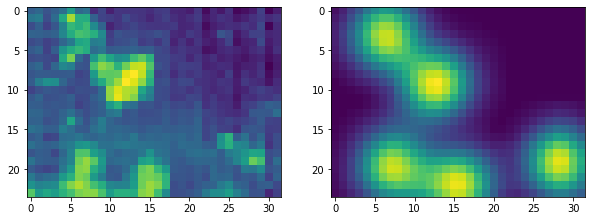

In [7]:
output_frame = model.predict(input_frame, verbose=0)

print(np.sum(output_frame) / config['dataset']["sum_of_values_for_one_person"])

fig, ax = plt.subplots(1,2, figsize=(10,4));
ax[0].imshow(input_frame.reshape(config['dataset']["IR_camera_resolution"]));
ax[1].imshow(output_frame[0][..., 0]);

Number of tested frames: 2347
Average inference time: 0.031761
Average FPS: 31.4851
Model Accuracy = 0.9795483596080102
Model F1 score = 0.9798091302816225
Predicted:
   165 frames with 0 persons
   83 frames with 1 persons
   220 frames with 2 persons
   333 frames with 3 persons
   1229 frames with 4 persons
   316 frames with 5 persons
   1 frames with 6 persons
Predicted correctly:
   162 frames with 0 persons
   78 frames with 1 persons
   205 frames with 2 persons
   328 frames with 3 persons
   1220 frames with 4 persons
   306 frames with 5 persons
mae: 0.10517487009357382
mse: 0.03238200663388619
mae_rounded: 0.020877716233489562
mse_rounded: 0.021729867916489135
mrae: 0.007832694219571086


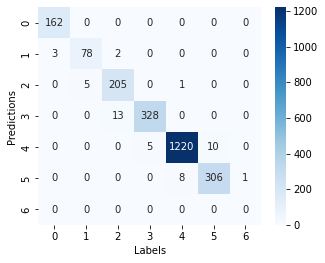

In [8]:
test_acc, test_f1, test_cm = evaluate(f'{MODELS_DIR}/{MODEL_NAME}.h5', 'keras', test_data_gen, config)

plt.figure(figsize=(5,4));
sns.heatmap(
    test_cm, annot=True, cmap="Blues", fmt='0.0f', 
    xticklabels=np.arange(config['dataset']["max_people_count"]+1), 
    yticklabels=np.arange(config['dataset']["max_people_count"]+1)
);
plt.xlabel('Labels');
plt.ylabel('Predictions');

## TF Lite conversion

In [9]:
def representative_dataset():
    repr_data_gen = ThermalDataset(
        data_path=Path('./data'), 
        sequences_names=config['dataset']["training_dirs"],
        person_point_weight=config['dataset']['sum_of_values_for_one_person'], 
        batch_size=1
    )
    
    frames_num = repr_data_gen.__len__()
    
    for i in tqdm(range(frames_num)):
        data = repr_data_gen[i][0]
        data = data.astype(np.float32)
        yield [data]

In [10]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
if MODEL_DTYPE == 'fp16':
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]
elif MODEL_DTYPE == 'int8':
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.target_spec.supported_types = [tf.int8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8
elif MODEL_DTYPE == 'uint8':
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.target_spec.supported_types = [tf.int8]
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

# Save the model.
with open(f'{MODELS_DIR}/{MODEL_NAME}_{MODEL_DTYPE}.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpvjflfgy4/assets


4.66686571932814


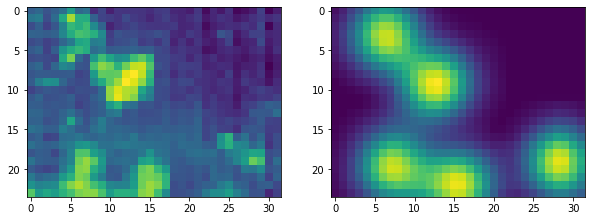

In [11]:
output_frame = tflite_inference(f'{MODELS_DIR}/{MODEL_NAME}_{MODEL_DTYPE}.tflite', input_frame)

print(np.sum(output_frame[0]) / config['dataset']["sum_of_values_for_one_person"])

fig, ax = plt.subplots(1,2, figsize=(10,4));
ax[0].imshow(input_frame[0,:,:,0]);
ax[1].imshow(output_frame[0][0,:,:,0]);

Number of tested frames: 2347
Average inference time: 0.000773
Average FPS: 1292.9767
Model Accuracy = 0.9795483596080102
Model F1 score = 0.9798091302816225
Predicted:
   165 frames with 0 persons
   83 frames with 1 persons
   220 frames with 2 persons
   333 frames with 3 persons
   1229 frames with 4 persons
   316 frames with 5 persons
   1 frames with 6 persons
Predicted correctly:
   162 frames with 0 persons
   78 frames with 1 persons
   205 frames with 2 persons
   328 frames with 3 persons
   1220 frames with 4 persons
   306 frames with 5 persons
mae: 0.10517487267117653
mse: 0.032382006621022585
mae_rounded: 0.020877716233489562
mse_rounded: 0.021729867916489135
mrae: 0.007832694219571086


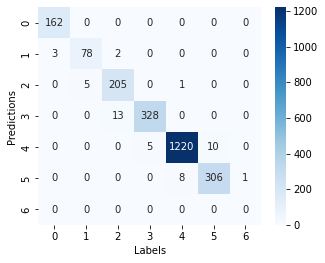

In [12]:
test_acc, test_f1, test_cm = evaluate(
    f'{MODELS_DIR}/{MODEL_NAME}_{MODEL_DTYPE}.tflite', 'tflite', test_data_gen, config)

plt.figure(figsize=(5,4));
sns.heatmap(
    test_cm, annot=True, cmap="Blues", fmt='0.0f', 
    xticklabels=np.arange(config['dataset']["max_people_count"]+1), 
    yticklabels=np.arange(config['dataset']["max_people_count"]+1)
);
plt.xlabel('Labels');
plt.ylabel('Predictions');

## Edge TPU

- [Edge TPU Compiler](https://coral.ai/docs/edgetpu/compiler/)

In [13]:
!edgetpu_compiler -s {MODELS_DIR}/{MODEL_NAME}_{MODEL_DTYPE}.tflite -o {MODELS_DIR}

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 1 ms.

Input model: ./data/model/model_fp32.tflite
Input size: 187.26KiB
Output model: model_fp32_edgetpu.tflite
Output size: 186.26KiB
On-chip memory used for caching model parameters: 0.00B
On-chip memory remaining for caching model parameters: 0.00B
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 0
Total number of operations: 13
Operation log: model_fp32_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 0
Number of operations that will run on CPU: 13

Operator                       Count      Status

RESIZE_NEAREST_NE

## TF Lite Micro conversion

- [TF Lite Micro build and convert models](https://www.tensorflow.org/lite/microcontrollers/build_convert)

In [14]:
!xxd -i {MODELS_DIR}/{MODEL_NAME}_{MODEL_DTYPE}.tflite > {MODELS_DIR}/{MODEL_NAME}_{MODEL_DTYPE}.cc

In [15]:
!sed -i 's/'{MODELS_DIR.replace('.', '_').replace('/','_')}'_'{MODEL_NAME}'_'{MODEL_DTYPE}'_tflite/g_model/g' {MODELS_DIR}/{MODEL_NAME}_{MODEL_DTYPE}.cc

In [16]:
!cat {MODELS_DIR}/{MODEL_NAME}_{MODEL_DTYPE}.cc | tail

  0x34, 0x00, 0x00, 0x00, 0x20, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0xcc, 0xff, 0xff, 0xff, 0x02, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x02,
  0x0c, 0x00, 0x10, 0x00, 0x0f, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x61, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x61, 0xf4, 0xff, 0xff, 0xff, 0x11, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x11, 0x0c, 0x00, 0x0c, 0x00, 0x0b, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x04, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x03
};
unsigned int g_model_len = 191752;


## Convert to ONNX

- [tf2onnx](https://github.com/onnx/tensorflow-onnx) package to convert from tensorflow to ONNX format

In [17]:
!python -m tf2onnx.convert --tflite {MODELS_DIR}/{MODEL_NAME}_fp32.tflite --output {MODELS_DIR}/{MODEL_NAME}.onnx

/home/mateusz/miniconda3/envs/thermo/lib/python3.9/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-12-08 15:56:58,559 - INFO - Using tensorflow=2.7.0, onnx=1.12.0, tf2onnx=1.13.0/2c1db5
2022-12-08 15:56:58,559 - INFO - Using opset <onnx, 13>
2022-12-08 15:56:58,606 - INFO - Optimizing ONNX model
2022-12-08 15:56:58,711 - INFO - After optimization: Cast -1 (1->0), Const +1 (25->26), Identity -1 (1->0), Reshape +2 (0->2), Transpose -44 (44->0)
2022-12-08 15:56:58,714 - INFO - 
2022-12-08 15:56:58,714 - INFO - Successfully converted TensorFlow model ./data/model/model_fp32.tflite to ONNX
2022-12-08 15:56:58,714 - INFO - Model inputs: ['serving_default_input_1:0']
2022-12-08 15:56:58,714 - INFO - Model outputs: ['StatefulPartitionedCall:0']
2022-12-08 15:56:58,714 - INFO - ONNX model is saved at ./data/model/model.o

## Convert to OpenVINO

- [OpenVINO toolkit](https://www.intel.com/content/www/us/en/developer/tools/openvino-toolkit/overview.html) to optimize and convert ONNX model to OpenVINO format

In [18]:
OpenVINO_PATH = '~/intel/openvino_2021'
DATA_TYPE = 'FP32' # FP32 FP16

In [19]:
!source {OpenVINO_PATH}/bin/setupvars.sh

[setupvars.sh] OpenVINO environment initialized


In [20]:
!python {OpenVINO_PATH}/deployment_tools/model_optimizer/mo.py \
    --input_model {MODELS_DIR}/{MODEL_NAME}.onnx \
    --model_name {MODEL_NAME}_{DATA_TYPE} \
    --output_dir {MODELS_DIR} \
    --data_type {DATA_TYPE} \
    --batch 1

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/mateusz/Research/thermo-hardware-benchmark/thermo/./data/model/model.onnx
	- Path for generated IR: 	/home/mateusz/Research/thermo-hardware-benchmark/thermo/./data/model
	- IR output name: 	model_FP32
	- Log level: 	ERROR
	- Batch: 	1
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	None
	- Reverse input channels: 	False
ONNX specific parameters:
	- Inference Engine found in: 	/home/mateusz/intel/openvino_2021.4.582/python/python3.9/openvino
Inference Engine version: 	2021.4.0-3839-cd81789d294-releases/2021/4
Model Optimizer version: 	2021.4.0-3839-cd81